In [1]:
#import libraries
#from __future__ import division, print_function, absolute_import

from tmm.tmm_core import (inc_tmm, unpolarized_RT, ellips,
                       position_resolved, find_in_structure_with_inf)
import numpy as np
#from numpy import pi, linspace, inf, array, loadtxt
import math
import cmath
import matplotlib.pyplot as plt

#import pandas as pd

# Import the function 'join' from the module 'os.path'
# This function automatically takes care of the slashes that need to be added when combining two paths.
from os.path import join

# "5 * degree" is 5 degrees expressed in radians
# "1.2 / degree" is 1.2 radians expressed in degrees
degree = np.pi/180

In [2]:
#path and definitions
dirpath = r'/Users/twenzel/ownCloudP/DreamHost/#Irridescent mineral project/Python simulation TTM/results/'

[400, 800, 0, 0.35]

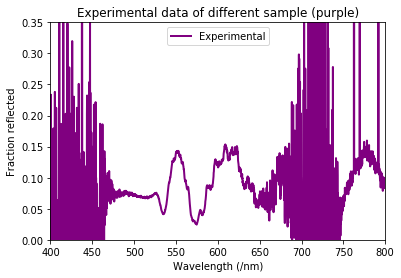

In [3]:
#Load experimental spectra so they can be plotted together with simulation
data = np.loadtxt('Spec5.csv',delimiter=';',skiprows=1)
#data.head() #display first five lines
expx = data[:,0] #accumulative depth value of layer
expy = data[:,1] #normalised gray value of layer

#plot experiments
plt.plot(expx,expy,'purple',lw=2,label="Experimental")
plt.legend()
plt.xlabel('Wavelength (/nm)')
plt.ylabel('Fraction reflected')
plt.title('Experimental data of different sample (purple)')
plt.axis([400, 800, 0, 0.35])

In [4]:
# Read in microscope image
def ExtractProfiles(inname, outname):
    # This program is (arbitrarily) set to work with images in the .tif format.

    I = plt.imread(inname+'.tif',format='tif') # import black-white image
    plt.imshow(I)
    plt.show()
    Image = I[:,:,0] #get rid of other image channels that are the same

    BulkNr = Image.shape[1]

    ProfileAll = np.sum(Image, axis=1)/BulkNr/255 #devide by index number og 8bit images (255)
    ProfileAll.shape

    #now only consider a third of the image for averaging each time
    ThirdPixels = int(np.floor(BulkNr/3))
    ProfileThird1 = np.sum(Image[:,1:ThirdPixels],axis=1)/ThirdPixels/255
    ProfileThird2 = np.sum(Image[:,ThirdPixels+1:2*ThirdPixels],axis=1)/ThirdPixels/255
    ProfileThird3 = np.sum(Image[:,(2*ThirdPixels)+1:3*ThirdPixels],axis=1)/ThirdPixels/255
    
    X = np.arange(len(ProfileThird3))
    plt.plot(X,ProfileAll,lw=2,label="Average over entire image")
    plt.plot(X,ProfileThird1,lw=2,label="First third")
    plt.plot(X,ProfileThird2,lw=2,label="Second third")
    plt.plot(X,ProfileThird3,lw=2,label="Last third")
    plt.legend()
    plt.xlabel('Depth in image pixels')
    plt.ylabel('Normalised density')
    plt.title('Material density in crossection')
    plt.show()
    
    #save the profiles
    np.savetxt(join(dirpath, outname+'_all.csv'), ProfileAll, delimiter=",")
    np.savetxt(join(dirpath, outname+'_1.csv'), ProfileThird1, delimiter=",")
    np.savetxt(join(dirpath, outname+'_2.csv'), ProfileThird2, delimiter=",")
    np.savetxt(join(dirpath, outname+'_3.csv'), ProfileThird3, delimiter=",")
    
    return ProfileAll, ProfileThird1, ProfileThird2, ProfileThird3

In [5]:
def Aggregate(profile,pxlscale,outname):

    #profile = np.around(profile,decimals=1) #for test purposes, use only one decimal place
    profile = np.around(profile,2) #round floating numbers of profile to 2 decimal places

    #loop to remove equal value layers 
    #initial attempt #idx = np.array(np.ediff1d(profile,to_begin=0),dtype=bool) #set true where the previous element is equal
    profile_aggregated = np.array([]) #initialise new profile array
    idx_aggregated = np.array([]) #initialise new index array
    for k,item in enumerate(profile):
        if k==0: #first item cannot be compared to previous
            profile_aggregated = item
            idx_aggregated = np.array([1])
            #elif k==(len(profile)-1): #last item
        elif item == profile[k-1]: #increase llayer-pixel-thicknes number if value is equal
            if idx_aggregated.shape[0]==1: #if there is nothing to index because there is just one element
                idx_aggregated += 1 
            else:
                idx_aggregated[-1] += 1
        else: #if layer value differs, record along with layer-pixel-thicknes value 1
            profile_aggregated = np.append(profile_aggregated, item)
            idx_aggregated = np.append(idx_aggregated, 1)

    #plot the plain aggregated array
    X = np.arange(len(profile_aggregated))
    plt.plot(X,profile_aggregated,lw=2)
    plt.xlabel('Aggregated array length')
    plt.ylabel('Normalised density')
    plt.title('Material density in crossection')
    plt.show()

    #change layer-thickness from pixel values to nanometer
    idx_aggregated_scaled = idx_aggregated * pxlscale
    
    #and add first (air) and last (solid)
    print(idx_aggregated_scaled.shape)
    idx_aggregated_scaled = np.append(idx_aggregated_scaled, np.inf)
    idx_aggregated_scaled = np.insert(idx_aggregated_scaled, 0, np.inf)
    profile_aggregated = np.append(profile_aggregated, 1)
    profile_aggregated = np.insert(profile_aggregated, 0, 0)

    #combine into one 2D array
    Aggregated_layers_profile = np.array([idx_aggregated_scaled, profile_aggregated]) 
    print(Aggregated_layers_profile.shape)
    
    #save the profile
    np.savetxt(join(dirpath, outname+'.csv'), Aggregated_layers_profile, delimiter=",")
    
    return Aggregated_layers_profile

In [6]:
#ALTERNATIVE# Load profile from .csv file

# #Read the layers' positions and gray values from structure profile.
# ftemp = np.loadtxt("ProfileTotalLong.csv",delimiter=',',skiprows=1) #or read incremental file name ("Plot Values "+str(n+20-N)+".xls")
# t_list = ftemp[:,0] #thickness of each layer
# gray_list = ftemp[:,1]

# # plt.figure(3)
# # plt.plot(t_list, gray_list, marker='o', ms = 10, alpha=1, color='b', label='Rock layers')
# # plt.xlabel('Wavelength (/nm)')
# # plt.ylabel('Refractive index')
# # plt.title('tenp plot')

# #Adds top and bottom inf layers to d list
# t_lists = np.append(t_list, np.inf)
# d_list = np.insert(t_lists, 0, np.inf)
# #correction = 0.05 #0.055
# #d_list = d_lists*(1-correction)

In [8]:
#generate list of refractive indicees
def generateNlist(outname,gray_list,Lamb):
    n_list = np.zeros((Lamb.size, gray_list.size), dtype=np.complex_)
    n1 = np.array([], dtype=np.complex_)
    
    air = 1.00029
    AS = 0.0162 #Sellmeier parameter for dispersion equation
    BS = 0.2658 #Sellmeier parameter for dispersion equation

    for a, wl in enumerate(Lamb):
        k = 1/wl
        #refractive index of the solid material at this wavelength
        n1 = math.sqrt( (1/( (-AS*(k**2))+BS ) ) +1)
        
        for b, gitem in enumerate(gray_list): #for each layer, calculate mix of air and solid material
            #real and imaginary part
            #n_list[a,b].real= air +((n1.real - air) * gitem)
            #n_list[a,b].imag= n1.imag * gitem
            n_list[a,b] = complex(air +((n1.real - air) * gitem), n1.imag * gitem)

    plt.plot(range(gray_list.size), n_list[1,:].imag, marker='o', ms = 10, alpha=1, color='b', label='img(n) of rock layers')
    plt.plot(range(gray_list.size), n_list[1,:].real, marker='d', ms = 10, alpha=1, color='g', label='real(n) of rock layers')
    plt.legend()
    plt.xlabel('Rock layer indicees')
    plt.ylabel('Refractive index')
    plt.title('Dispersion relations, imaginary part and real part at '+ str(Lamb[0]) +'nm')
    plt.show()
    
    plt.imshow(n_list.real) #dislay the entire matrix of the real part
    plt.ylabel('Wavelength in nm')
    plt.xlabel('Rock layer indicees')
    plt.title('Real part of refrative index')
    plt.show()
    
    plt.imshow(n_list.imag) #dislay the entire matrix of the imaginary part
    plt.ylabel('Wavelength in nm')
    plt.xlabel('Rock layer indicees')
    plt.title('Imaginary part of refrative index')
    plt.show()

    #save to file
    np.savetxt(join(dirpath, outname+'_real.csv'), n_list.real, delimiter=",")
    np.savetxt(join(dirpath, outname+'_imag.csv'), n_list.imag, delimiter=",")
    
    return n_list

In [9]:
def reflectionsim(Lamb, Angles, n_list, d_list, c_list, N):
    RNA = np.zeros((Lamb.size,angles.size))

    for i in range(Lamb.size):
        for j in range(angles.size):
            RNA[i,j] = inc_tmm('s',n_list[i,:], d_list, c_list, Angles[j]*degree, Lamb[i])['R']
            RNA[i,j] += inc_tmm('p',n_list[i,:], d_list, c_list, Angles[j]*degree, Lamb[i])['R']
    
    #both polarisations, averaged 
    RNA = RNA/2
    RNAmean = np.mean(RNA, axis=1)
    
    return RNAmean

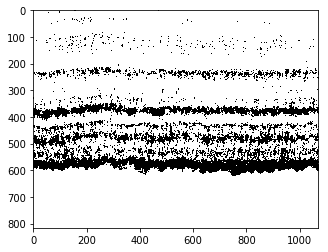

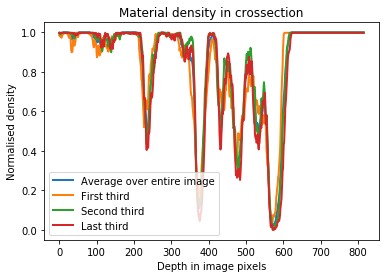

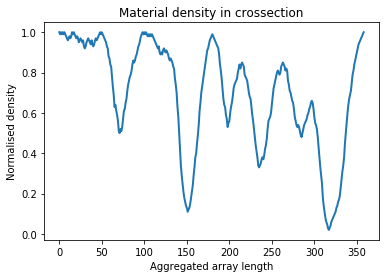

(359,)
(2, 361)


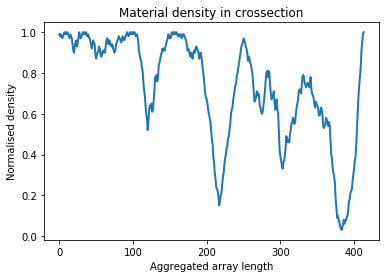

(414,)
(2, 416)


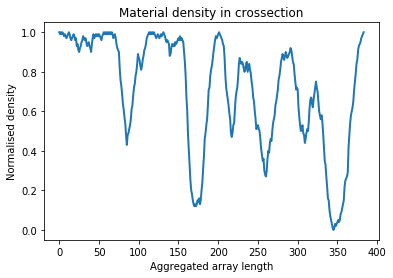

(384,)
(2, 386)


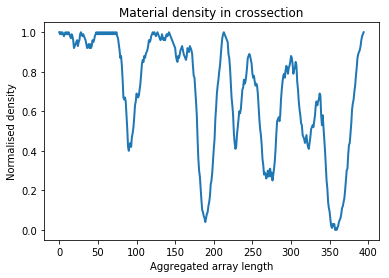

(395,)
(2, 397)


In [79]:
#Call functions to load image as well as create, aggreagate and scale profiles

#call profile extraction function
ImName = 'Picture1_bw' # INPUT NAME OF TEM-IMAGE
SaveName = 'Gracscale_profile' # CHOOSE NAME TO SAVE
p0,p1,p2,p3 = ExtractProfiles(ImName, SaveName+'_raw')

#call profile aggregation and scaling function
PxlScale = 200/120 #200nm is 120 pixel
PGrayAll = Aggregate(p0,PxlScale,SaveName+'_aggreg_scaled_pAll')
PGray1 = Aggregate(p1,PxlScale,SaveName+'_aggreg_scaled_p1')
PGray2 = Aggregate(p2,PxlScale,SaveName+'_aggreg_scaled_p2')
PGray3 = Aggregate(p3,PxlScale,SaveName+'_aggreg_scaled_p3')


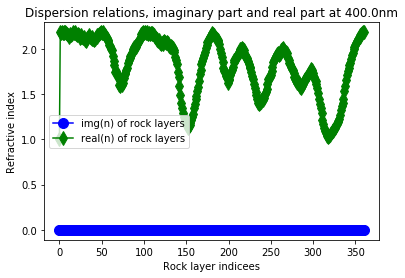

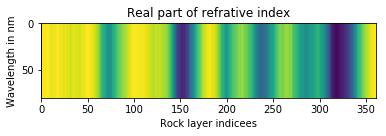

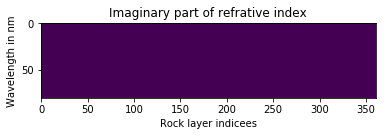

In [80]:
#Make refractive index array out of gray level array
grayList = PGrayAll[1,:]

#define wavelength and angular intervals
lamb= np.linspace(400,800,num=81) #num=81,every 5nm) #40
angles= np.linspace(-17,17,35) #19

#call refractive index generation function
SaveName = 'n_matrix_0' # CHOOSE NAME TO SAVE
n_list = generateNlist(SaveName,grayList,lamb)

In [59]:
#Call the transfer matrix simulation (TMM) function
d_list = PGrayAll[0,:] #layer thickness array

# C_list: creat coherency list for the simulation. Same lenght as d_list. First and last value must be 'i' for incoherent.
c_list = ['c']*len(d_list)
c_list[0] = 'i'
c_list[-1] = 'i'

#call reflection simulation function
N = 1 #no loop here
n = 0
RNAmeans = np.zeros((N, lamb.size)) #initialise array
RNAmeans[n,:] = reflectionsim(lamb, angles, n_list, d_list, c_list, N)

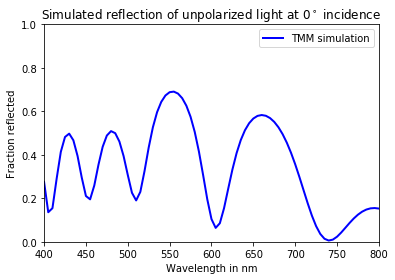

In [60]:
#plot the results vs experiments
# ##plt.figure(0)
# #plt.plot(lamb,RNAmeans[n,:],'--')
# plt.plot(lamb,RNAmeans[n,:],'blue',lw=2,label="Average")
# plt.plot(expx,expy,'purple',lw=2,label="Experimental")
# plt.legend()
# plt.xlabel('Wavelength (/nm)')
# plt.ylabel('Fraction reflected')
# plt.title('Simulated reflection of unpolarized light at 0$^\circ$ incidence (blue), '
#             'Experimental data of different sample (purple)')
# plt.axis([400, 800, 0, 1])
# plt.show()

plt.plot(lamb,RNAmeans[n,:],'blue',lw=2,label="TMM simulation")
plt.legend()
plt.xlabel('Wavelength in nm')
plt.ylabel('Fraction reflected')
plt.title('Simulated reflection of unpolarized light at 0$^\circ$ incidence')
plt.axis([400, 800, 0, 1])
plt.show()

In [78]:
#save simulation data in a text file made out of columns delimited by a space
Filename1 = "RNAmeansAll.csv"
filepathRNA = join(dirpath, Filename1)
np.savetxt(filepathRNA, RNAmeans, delimiter=",")

In [62]:
# FROM https://scipython.com/blog/converting-a-spectrum-to-a-colour/
def xyz_from_xy(x, y):
    """Return the vector (x, y, 1-x-y)."""
    return np.array((x, y, 1-x-y))

class ColourSystem:
    """A class representing a colour system.

    A colour system defined by the CIE x, y and z=1-x-y coordinates of
    its three primary illuminants and its "white point".

    TODO: Implement gamma correction

    """

    # The CIE colour matching function for 380 - 780 nm in 5 nm intervals
    cmf = np.loadtxt('cie-cmf.txt', usecols=(1,2,3))

    def __init__(self, red, green, blue, white):
        """Initialise the ColourSystem object.

        Pass vectors (ie NumPy arrays of shape (3,)) for each of the
        red, green, blue  chromaticities and the white illuminant
        defining the colour system.

        """

        # Chromaticities
        self.red, self.green, self.blue = red, green, blue
        self.white = white
        # The chromaticity matrix (rgb -> xyz) and its inverse
        self.M = np.vstack((self.red, self.green, self.blue)).T 
        self.MI = np.linalg.inv(self.M)
        # White scaling array
        self.wscale = self.MI.dot(self.white)
        # xyz -> rgb transformation matrix
        self.T = self.MI / self.wscale[:, np.newaxis]

    def xyz_to_rgb(self, xyz, out_fmt=None):
        """Transform from xyz to rgb representation of colour.

        The output rgb components are normalized on their maximum
        value. If xyz is out the rgb gamut, it is desaturated until it
        comes into gamut.

        By default, fractional rgb components are returned; if
        out_fmt='html', the HTML hex string '#rrggbb' is returned.

        """

        rgb = self.T.dot(xyz)
        if np.any(rgb < 0):
            # We're not in the RGB gamut: approximate by desaturating
            w = - np.min(rgb)
            rgb += w
        if not np.all(rgb==0):
            # Normalize the rgb vector
            rgb /= np.max(rgb)

        if out_fmt == 'html':
            return self.rgb_to_hex(rgb)
        return rgb

    def rgb_to_hex(self, rgb):
        """Convert from fractional rgb values to HTML-style hex string."""

        hex_rgb = (255 * rgb).astype(int)
        return '#{:02x}{:02x}{:02x}'.format(*hex_rgb)

    def spec_to_xyz(self, spec):
        """Convert a spectrum to an xyz point.

        The spectrum must be on the same grid of points as the colour-matching
        function, self.cmf: 380-780 nm in 5 nm steps.

        """

        XYZ = np.sum(spec[:, np.newaxis] * self.cmf, axis=0)
        den = np.sum(XYZ)
        if den == 0.:
            return XYZ
        return XYZ / den

    def spec_to_rgb(self, spec, out_fmt=None):
        """Convert a spectrum to an rgb value."""

        xyz = self.spec_to_xyz(spec)
        return self.xyz_to_rgb(xyz, out_fmt)

illuminant_D65 = xyz_from_xy(0.3127, 0.3291)
cs_hdtv = ColourSystem(red=xyz_from_xy(0.67, 0.33),
                       green=xyz_from_xy(0.21, 0.71),
                       blue=xyz_from_xy(0.15, 0.06),
                       white=illuminant_D65)

cs_smpte = ColourSystem(red=xyz_from_xy(0.63, 0.34),
                        green=xyz_from_xy(0.31, 0.595),
                        blue=xyz_from_xy(0.155, 0.070),
                        white=illuminant_D65)

cs_srgb = ColourSystem(red=xyz_from_xy(0.64, 0.33),
                       green=xyz_from_xy(0.30, 0.60),
                       blue=xyz_from_xy(0.15, 0.06),
                       white=illuminant_D65)

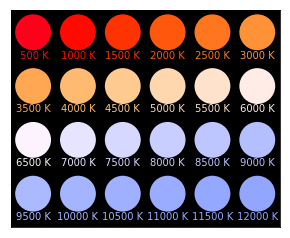

(81,)


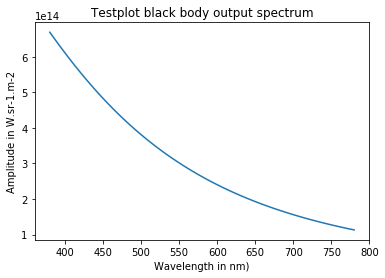

In [71]:
#### EXAMBLE ONLY
#import numpy as np
from scipy.constants import h, c, k
#import matplotlib.pyplot as plt
from matplotlib.patches import Circle

#from colour_system import cs_hdtv
cs = cs_hdtv

def planck(lam, T):
    """ Returns the spectral radiance of a black body at temperature T.

    Returns the spectral radiance, B(lam, T), in W.sr-1.m-2 of a black body
    at temperature T (in K) at a wavelength lam (in nm), using Planck's law.

    """

    lam_m = lam / 1.e9
    fac = h*c/lam_m/k/T
    B = 2*h*c**2/lam_m**5 / (np.exp(fac) - 1)
    return B

fig, ax = plt.subplots()

# The grid of visible wavelengths corresponding to the grid of colour-matching
# functions used by the ColourSystem instance.
lam = np.arange(380., 781., 5)

for i in range(24):
    # T = 500 to 12000 K
    T = 500*i + 500

    # Calculate the black body spectrum and the HTML hex RGB colour string
    # it looks like
    spec = planck(lam, T)
    html_rgb = cs.spec_to_rgb(spec, out_fmt='html')

    # Place and label a circle with the colour of a black body at temperature T
    x, y = i % 6, -(i // 6)
    circle = Circle(xy=(x, y*1.2), radius=0.4, fc=html_rgb)
    ax.add_patch(circle)
    ax.annotate('{:4d} K'.format(T), xy=(x, y*1.2-0.5), va='center',
                ha='center', color=html_rgb)

# Set the limits and background colour; remove the ticks
ax.set_xlim(-0.5,5.5)
ax.set_ylim(-4.35, 0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('k')
# Make sure our circles are circular!
ax.set_aspect("equal")
plt.show()

print(spec.shape)
plt.plot(lam,spec)
plt.xlabel('Wavelength in nm)')
plt.ylabel('Amplitude in W.sr-1.m-2')
plt.title('Testplot black body output spectrum')
plt.show()

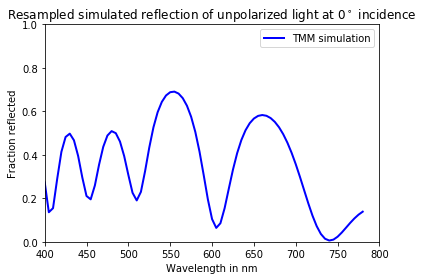

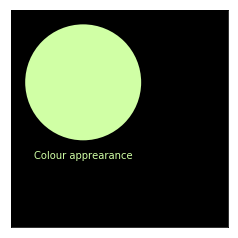

In [77]:
#Resample the elements corresponding to a colour tool and plot resulting colour
#only works if intersection of wavelength arrays exsist

Spectrum = RNAmeans[n,:]
wlsSpec = lamb
# plt.plot(wlsSpec,Spectrum,'blue',lw=2,label="TMM simulation")
# plt.legend()
# plt.xlabel('Wavelength in nm')
# plt.ylabel('Fraction reflected')
# plt.title('Simulated reflection of unpolarized light at 0$^\circ$ incidence')
# plt.axis([400, 800, 0, 1])
# plt.show()

# The grid of visible wavelengths corresponding to the grid of colour-matching
# functions used by the ColourSystem instance.
wlsTool = np.arange(380., 781., 5)

# An intersection of both lists, stored in `intersection`  #intersection = [[x for x in sublist if x in list1] for sublist in list2]
# But here there are np arrays instead of lists, so, use boolean intersect:
BoleanIntersection = np.in1d(wlsSpec, wlsTool)
BoolIdx = np.nonzero(BoleanIntersection)
wlsIntersec = wlsSpec[BoolIdx]
SpecIntersec = Spectrum[BoolIdx]
#add back values for 380 to 395nm!
wlsIntersec = np.insert(wlsIntersec, 0, [380, 385, 390, 395])
SpecIntersec = np.insert(SpecIntersec, 0, [0, 0, 0, 0])

#plot intersected results
plt.plot(wlsIntersec,SpecIntersec,'blue',lw=2,label="TMM simulation")
plt.legend()
plt.xlabel('Wavelength in nm')
plt.ylabel('Fraction reflected')
plt.title('Resampled simulated reflection of unpolarized light at 0$^\circ$ incidence')
plt.axis([400, 800, 0, 1])
plt.show()

#call colour conversion function
html_rgb = cs.spec_to_rgb(SpecIntersec, out_fmt='html')

#plot the visual output colour as circle(s)
fig, ax = plt.subplots()
# Place and label a circle with the colour of a black body at temperature T
x, y = 0 % 6, -(0 // 6)
circle = Circle(xy=(x, y*1.2), radius=0.4, fc=html_rgb)
ax.add_patch(circle)
ax.annotate('Colour apprearance'.format(T), xy=(x, y*1.2-0.5), va='center', ha='center', color=html_rgb)
# Set the limits and background colour; remove the ticks
ax.set_xlim(-0.5,1)
ax.set_ylim(-1, 0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('k')
# Make sure our circles are circular!
ax.set_aspect("equal")
plt.show()

#test plot to see if the colour tool is working correctly
# #vector with only one positive value (monochromatic)
# testcolour = np.zeros_like(wlsTool)
# testcolour[wlsTool==500] = 1
# #print(testcolour)
# html_rgb = cs.spec_to_rgb(testcolour, out_fmt='html')
# fig, ax = plt.subplots()
# x, y = 0 % 6, -(0 // 6)
# circle = Circle(xy=(x, y*1.2), radius=0.4, fc=html_rgb)
# ax.add_patch(circle)
# ax.annotate('Colour apprearance'.format(T), xy=(x, y*1.2-0.5), va='center', ha='center', color=html_rgb)
# ax.set_xlim(-0.5,1)
# ax.set_ylim(-1, 0.5)
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_facecolor('k')
# ax.set_aspect("equal")
# plt.show()
# #it works :-)